In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.iolib.smpickle import save_pickle, load_pickle
from sklearn.model_selection import TimeSeriesSplit


from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('LCD_SanFrancisco.csv')


In [3]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.rename(columns={'DATE': 'Date'}, inplace=True)
df.sort_values(by = "Date", inplace=True)

print('Data successfully loaded and transformed!')
print('Shape of dataframe:', df.shape)

Data successfully loaded and transformed!
Shape of dataframe: (758, 124)


In [4]:
df_trim = df[['DailyAverageDryBulbTemperature', 'Date']][df['REPORT_TYPE']=='SOD  '].copy()
df_trim.rename(columns = {'DailyAverageDryBulbTemperature':'avtemp'}, inplace=True)
df_trim.avtemp = df_trim.avtemp.astype(float)
df_trim.index = df_trim.Date
df_trim.drop(columns = "Date", inplace = True)
df_trim.to_csv('SF_AVTEMP.csv')

print('Shape of dataframe:', df_trim.shape)
print(df_trim.head())

Shape of dataframe: (364, 1)
                     avtemp
Date                       
2023-01-01 23:59:00    55.0
2023-01-02 23:59:00    49.0
2023-01-03 23:59:00    50.0
2023-01-04 23:59:00    54.0
2023-01-05 23:59:00    55.0


In [5]:
df = pd.read_csv('SF_AVTEMP.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by = "Date", inplace=True)
df.index = df.Date
df.drop(columns = "Date", inplace = True)

In [6]:
df.head()

,avtemp
Date,
2023-01-01 23:59:00,55.0
2023-01-02 23:59:00,49.0
2023-01-03 23:59:00,50.0
2023-01-04 23:59:00,54.0
2023-01-05 23:59:00,55.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2023-01-01 23:59:00 to 2023-12-30 23:59:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   avtemp  344 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


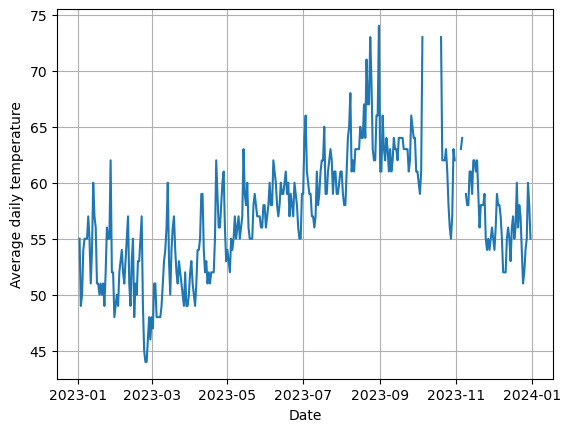

In [8]:
plt.plot(df)
plt.xlabel('Date')
plt.ylabel('Average daily temperature')
plt.grid()
plt.show()

In [9]:
# Get skewness
print('Skewness of data (pandas method):', df['avtemp'].skew())

Skewness of data (pandas method): 0.15743269958955147


In [10]:
# Get kurtosis
print('Excess kurtosis of data (pandas method):', df['avtemp'].kurtosis())

Excess kurtosis of data (pandas method): 0.13310870760060434


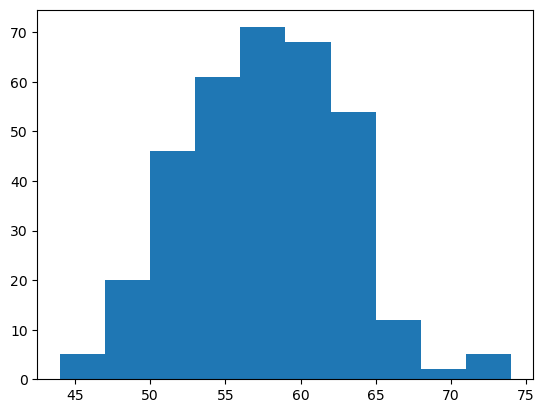

In [11]:
plt.hist(df['avtemp'])
plt.show()

Bin edges: [44. 47. 50. 53. 56. 59. 62. 65. 68. 71. 74.]
Number of observations within each bin: [ 5. 20. 46. 61. 71. 68. 54. 12.  2.  5.]


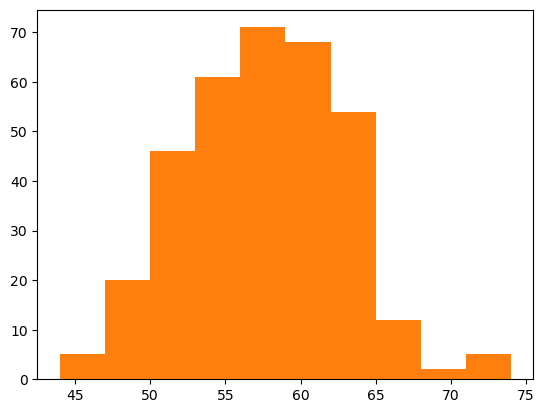

In [12]:
# NOTE: If you run this code in your local environment, you will also print the chart
print('Bin edges:', list(plt.hist(df['avtemp']))[1])
print('Number of observations within each bin:', list(plt.hist(df['avtemp']))[0])

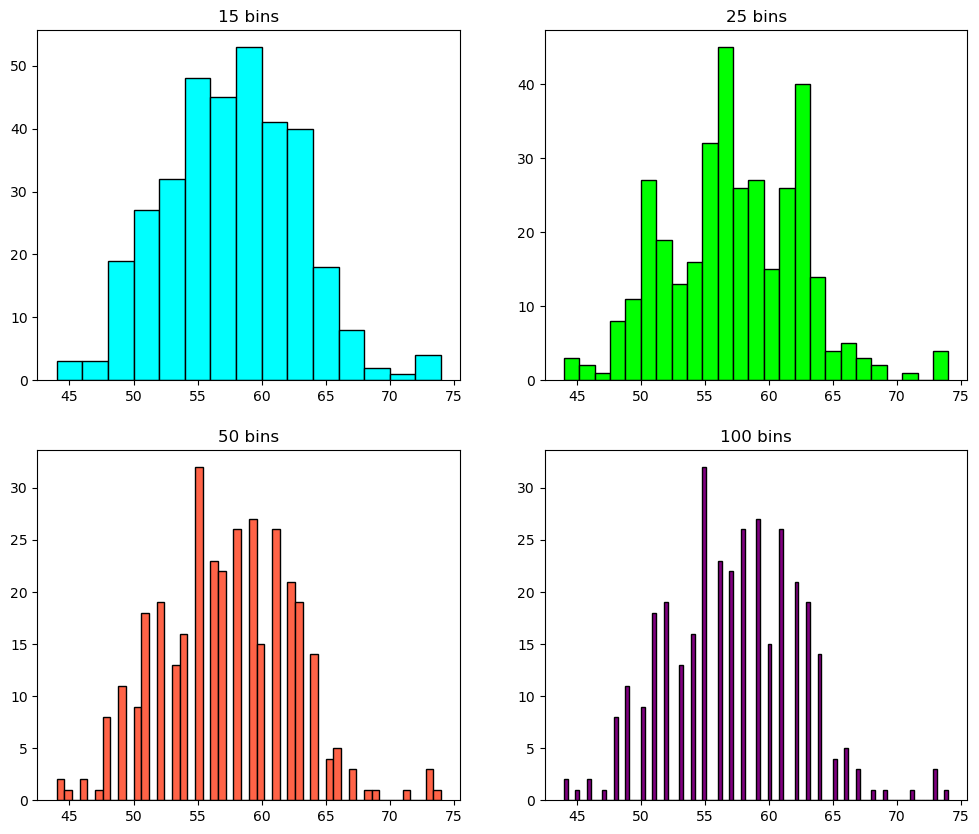

In [13]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Plot the first histogram with 15 bins
plt.subplot(2, 2, 1)
plt.hist(df, bins=15, edgecolor='k', linewidth=1, color='cyan')
plt.title('15 bins')

# Plot the second histogram with 25 bins
plt.subplot(2, 2, 2)
plt.hist(df, bins=25, edgecolor='k', linewidth=1, color='lime')
plt.title('25 bins')

# Plot the third histogram with 50 bins
plt.subplot(2, 2, 3)
plt.hist(df, bins=50, edgecolor='k', linewidth=1, color='tomato')
plt.title('50 bins')

# Plot the fourth histogram with 100 bins
plt.subplot(2, 2, 4)
plt.hist(df, bins=100, edgecolor='k', linewidth=1, color='purple')
plt.title('100 bins')

# Show the plot
plt.show()


/Users/aseemmehrotra/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aseemmehrotra/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aseemmehrotra/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aseemmehrotra/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

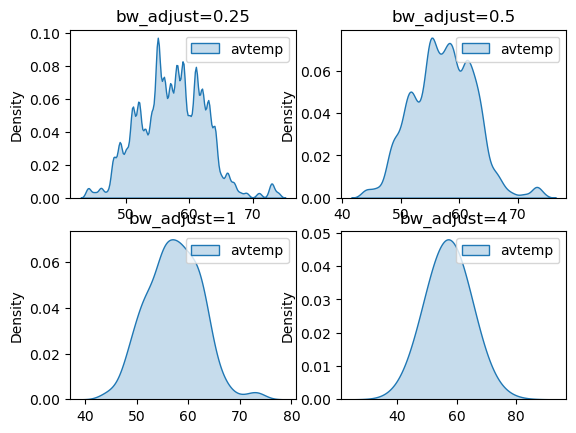

In [14]:
# Plot the first kernel density plot with bw_adjust=0.25
plt.subplot(2, 2, 1)
sns.kdeplot(df, bw_adjust=0.25, color='cyan', fill = True)
plt.title('bw_adjust=0.25')

# Plot the second kernel density plot with bw_adjust=0.5
plt.subplot(2, 2, 2)
sns.kdeplot(df, bw_adjust=0.5, color='lime', fill = True)
plt.title('bw_adjust=0.5')

# Plot the third kernel density plot with bw_adjust=1
plt.subplot(2, 2, 3)
sns.kdeplot(df, bw_adjust=1, color='tomato', fill = True)
plt.title('bw_adjust=1')

# Plot the fourth kernel density plot with bw_adjust=4
plt.subplot(2, 2, 4)
sns.kdeplot(df, bw_adjust=4, color='purple', fill = True)
plt.title('bw_adjust=4')

# Show the plot
plt.show()

In [15]:
nan_count = df['avtemp'].isnull().sum()
print(f"Number of NaN values: {nan_count}")

# Find and count infinite values
inf_count = np.isinf(df['avtemp']).sum()
print(f"Number of infinite values: {inf_count}")

Number of NaN values: 20
Number of infinite values: 0


In [16]:
df = df.ffill()

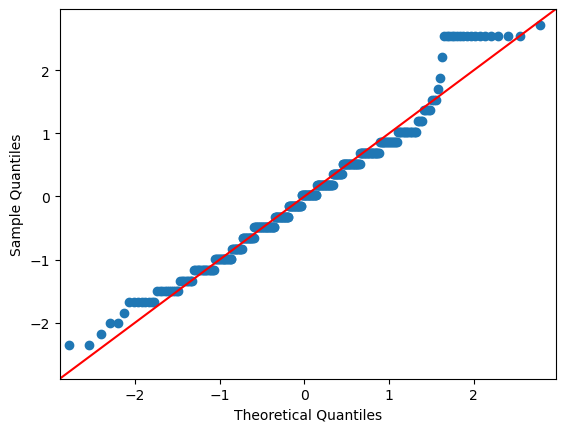

In [17]:

# Plot
qqplot(
    df['avtemp'], 
    fit = True, # We don't know the mean and standard deviation of the theoretical normal, so we fit some estimated values
    line = '45' # Plot 45º line
    )
plt.show()


In [18]:
# Run the jarque bera test
test_jb = jarque_bera(df['avtemp'])
print('JB t-statistic:', test_jb[0]) 
print('JB p-value:', test_jb[1]) 

JB t-statistic: 16.552704238653856
JB p-value: 0.000254463762453729


* The Q-Q plot and JB t-test test show that the data doesn't follow the normal distribution

In [20]:
# Run test and print results
test_df = adfuller(df['avtemp'], maxlag=1) 
print('Critical values:', test_df[4])
print('DF t-statistic:', test_df[0])
print('DF p-value:', test_df[1])

Critical values: {'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}
DF t-statistic: -4.373898270223342
DF p-value: 0.00033004763226097354


The Dickey-Fuller (DF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Here's the core idea:

* **Null Hypothesis (H0):** The time series has a unit root, meaning it's a random walk and therefore non-stationary (I(1)).
* **Alternative Hypothesis (H1):** The time series does not have a unit root and is stationary (or can be made stationary by differencing).

* p-value for DF (Dickey-Fuller) test is less than the 1%, 5% and 10% significant levels.
* We can reject the null hypothesis that the process is integrated.
* We assume that our process is not integrated
* According to this test, temperature values follow a stationary process

In [22]:
# Run test and print results
test_df = adfuller(df['avtemp'], maxlag = None, regression = 'c') 
print('Critical values:', test_df[4])
print('ADF t-statistic:', test_df[0])
print('ADF p-value:', test_df[1])

Critical values: {'1%': -3.448748905151901, '5%': -2.8696473721448728, '10%': -2.5710891239349585}
ADF t-statistic: -2.4672714135756513
ADF p-value: 0.12364194701912284


* p-value for ADF (Augmented Dickey-Fuller) test is more than the 1%, 5% and 10% significance levels.
* We fail to reject the null hypothesis that the process is integrated.
* We assume that our process is integrated
* According to this test, temperature values do not follow a stationary process

In [24]:
# Run the test
test_kpss = kpss(df['avtemp'])
print('Critical values:', test_kpss[3])
print('KPSS t-statistic:', test_kpss[0])
print('KPSS p-value:', test_kpss[1])

Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS t-statistic: 1.6474760614715989
KPSS p-value: 0.01


/var/folders/sq/vvk9r1h54773x5hgxgcqlhqw0000gn/T/ipykernel_67475/4284480001.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  test_kpss = kpss(df['avtemp'])


* p-value for KPSS test is less than the 1%, 5% and 10% critical values.
* We can reject the null hypothesis that the process is not integrated.
* We assume that our process is integrated
* According to this test, temperature values do not follow a stationary process

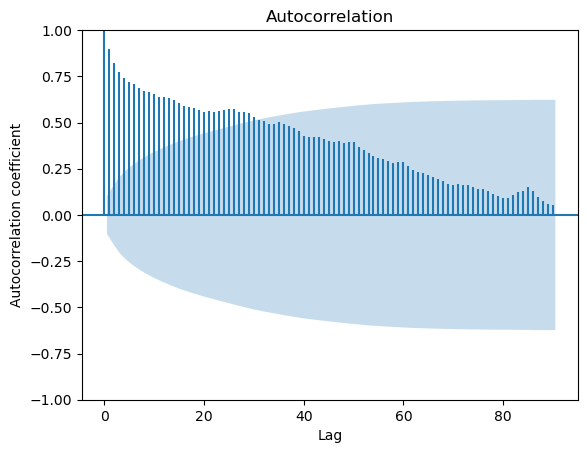

In [26]:
# Plot ACF
plot_acf(df['avtemp'], lags = 90, marker = '')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation coefficient')
plt.show()

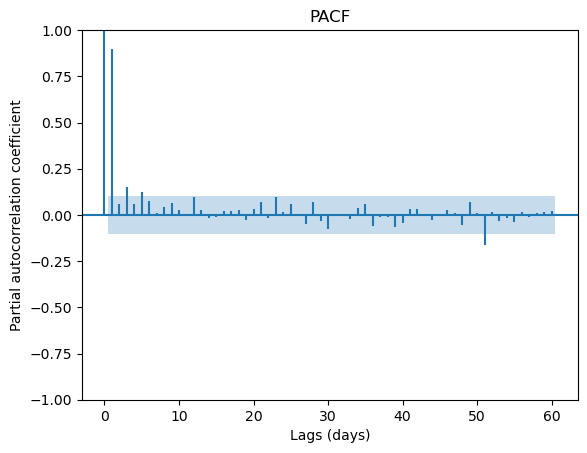

In [27]:
# Plot PACF
plot_pacf(df['avtemp'], 
          method = 'ywm', 
          title = 'PACF', 
          lags = 60, 
          marker = '')
plt.ylabel('Partial autocorrelation coefficient')
plt.xlabel('Lags (days)')
plt.show()

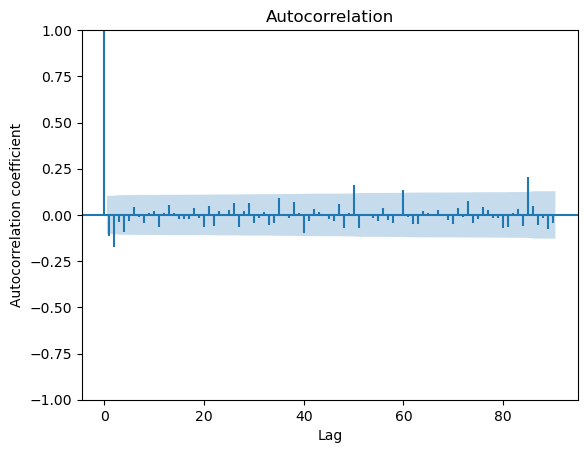

In [28]:
df['FD avtemp'] = df['avtemp'].diff()

# Plot 
plot_acf(df['FD avtemp'][1:], lags = 90, marker = '')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation coefficient')
plt.show()

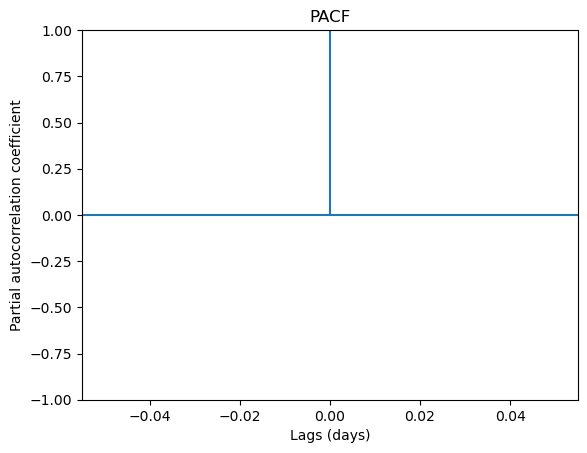

In [29]:
# Plot PACF
plot_pacf(df['FD avtemp'], 
          method = 'ywm', 
          title = 'PACF', 
          lags = 60, 
          marker = '')
plt.ylabel('Partial autocorrelation coefficient')
plt.xlabel('Lags (days)')
plt.show()

In [30]:
# Run the test
lb_df = acorr_ljungbox(df['avtemp'], period = 365)

if lb_df['lb_pvalue'][lb_df['lb_pvalue']!=0].any() == False:
    print('Serial correlation was found for all {} lags considered'.format(len(lb_df)))
else:
    print('No serial correlation was found')

No serial correlation was found


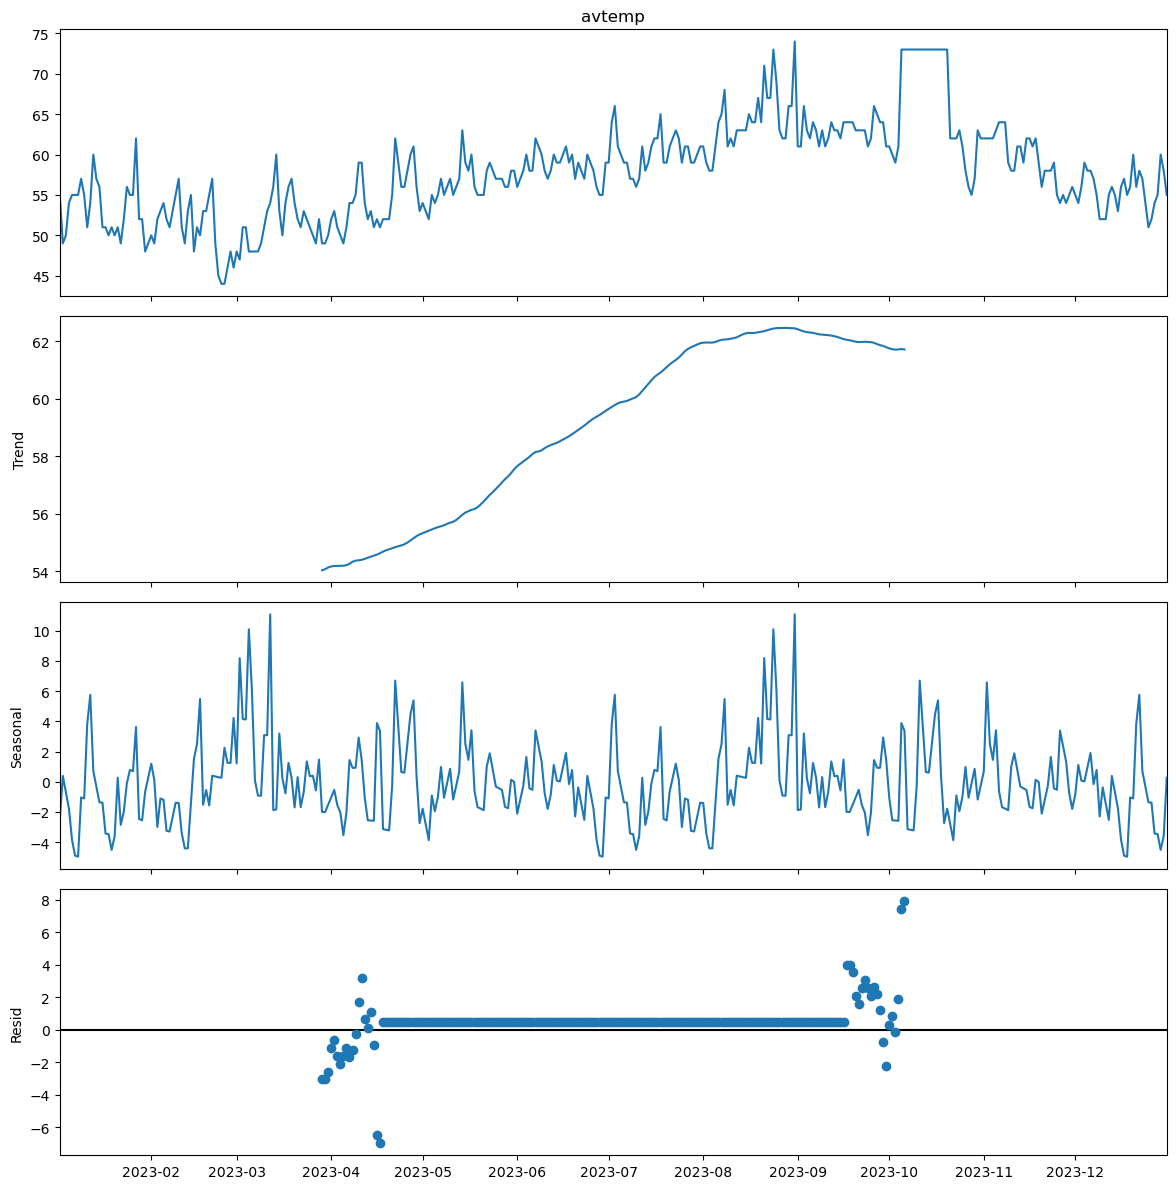

In [31]:
# Calculate decomposition
seasonal = seasonal_decompose(x = df['avtemp'], period = 172, model = 'additive')

# Plot
plt.rc("figure",figsize=(12,12))
seasonal.plot()
plt.show()

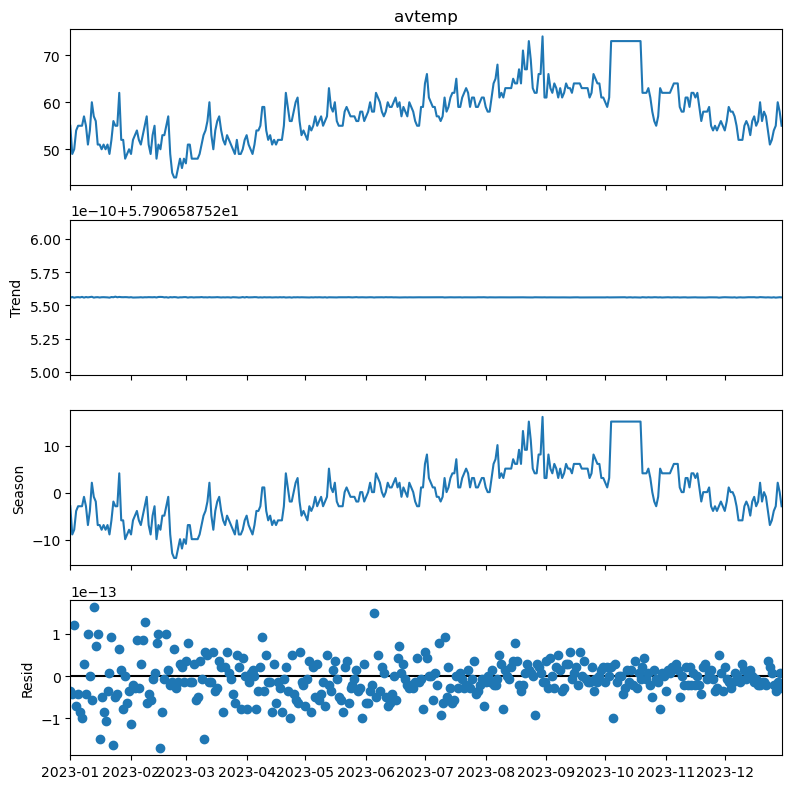

In [32]:
# STL decomposition
dec = STL(df.resample('D').mean().ffill()['avtemp'], period = 365, seasonal = 365)
res = dec.fit()
plt.rc("figure",figsize=(8,8))
res.plot()
plt.show()

In [33]:
# prepare the full data (2014 to 2023)
df_full = pd.read_csv('LCD_SanFrancisco_full.csv')
df_full['DATE'] = pd.to_datetime(df_full['DATE'])
df_full.rename(columns={'DATE': 'Date'}, inplace=True)
df_full.sort_values(by = "Date", inplace=True)
print('Data successfully loaded and transformed!')
print('Shape of dataframe:', df.shape)





Data successfully loaded and transformed!
Shape of dataframe: (364, 2)


In [34]:
df_full_trim = df_full[['DailyAverageDryBulbTemperature', 'Date']][df_full['REPORT_TYPE']=='SOD  '].copy()
df_full_trim.rename(columns = {'DailyAverageDryBulbTemperature':'avtemp'}, inplace=True)
df_full_trim.avtemp = df_full_trim.avtemp.astype(float)
df_full_trim.index = df_full_trim.Date
df_full_trim.drop(columns = "Date", inplace = True)
df_full_trim.to_csv('SF_AVTEMP_full.csv')

In [35]:
df_prep = pd.read_csv('SF_AVTEMP_full.csv')
df_prep['Date'] = pd.to_datetime(df_prep['Date'])
df_prep.sort_values(by = "Date", inplace=True)
df_prep.index = df_prep.Date
df_prep.drop(columns = "Date", inplace = True)

In [36]:
# Resample the data into monthly intervals and calculate the mean
df_monthly = df_prep.resample('M').mean('avtemp')

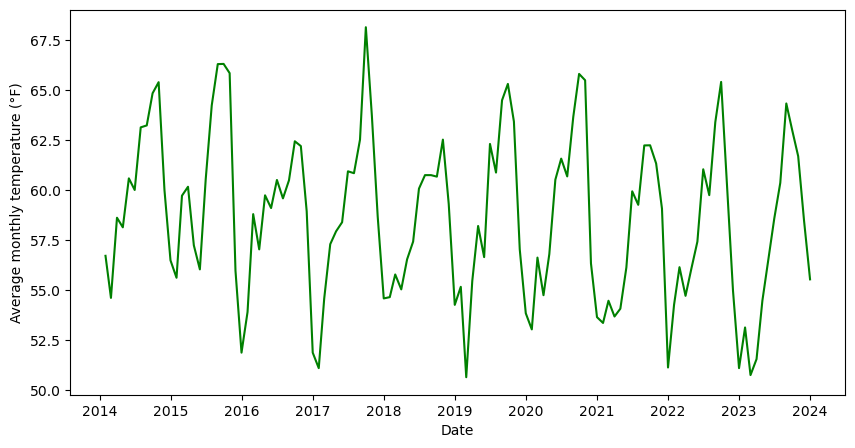

In [37]:
# Plot resulting DataFrame
plt.figure(figsize = (10,5))
plt.plot(df_monthly['avtemp'], color = 'green')
plt.xlabel('Date')
plt.ylabel('Average monthly temperature (°F)')
plt.show()

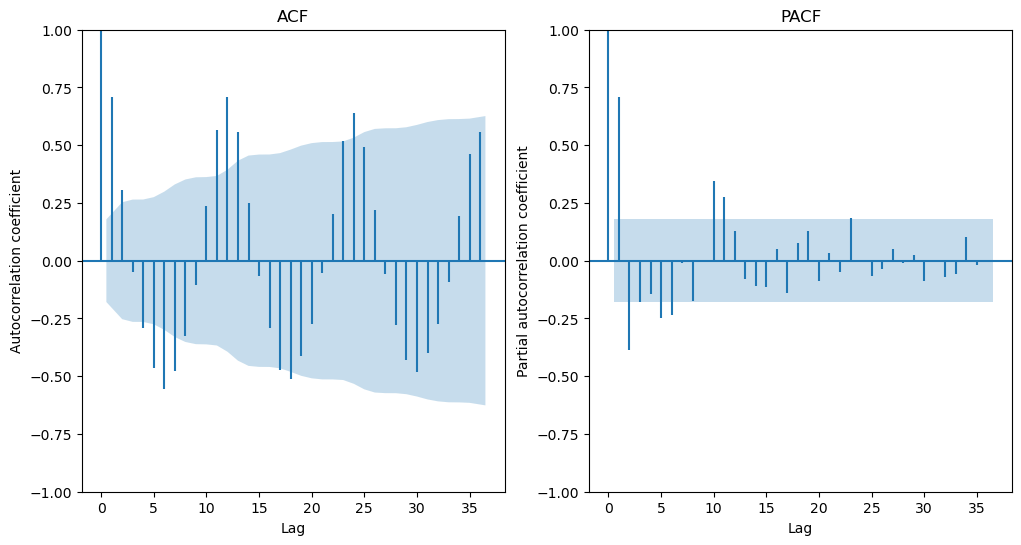

In [38]:
# Plot ACF & PACF
fig, ax = plt.subplots(1, 2, figsize = (12,6))

plot_acf(df_monthly['avtemp'], lags = 36, marker = '', ax = ax[0])
ax[0].set_title('ACF')
ax[0].set_ylabel('Autocorrelation coefficient')
ax[0].set_xlabel('Lag')

plot_pacf(df_monthly['avtemp'], lags = 36, marker = '', ax = ax[1])
ax[1].set_title('PACF')
ax[1].set_ylabel('Partial autocorrelation coefficient')
ax[1].set_xlabel('Lag')

plt.show()

The charts above show that the ACF has a much richer structure than the PACF:

* The monthly ACF shows a significant correlation that slowly decays as we go further back in time. It is significant up to 12 lags (one year). It also shows that temperatures are negatively correlated after 7 lags or so and that the cycle repeats every year. This is a reflection of the seasons of the year.

* The monthly PACF dies down quite quickly, although it spikes back up at lags 10–12 and, to a lesser extent, at lag 23.

* The ACF shows that data follows a SARIMA process with a seasonal period of about a year. Since we have aggregated the data at the monthly level, this means the s parameter of the SARIMA should be 12.

* The MA part of the non-seasonal component, q, doesn’t seem to play a big role, as per the shape of the PACF. The seasonal MA part is not as well-defined in the PACF. The spikes around lags 12 and 23 could be a sign of a slowly-decaying seasonal PACF or seasonal AR components.

In [40]:
# Define train/test sets
cutoff = 12
train = df_monthly['avtemp'][:-cutoff]
test = df_monthly['avtemp'][-cutoff:]

print('Length of train set:', len(train))
print('Length of test set:', len(test))

Length of train set: 108
Length of test set: 12


In [41]:
# Define a list for different combinations of parameter values
params = [
    {'p':1, 'd':0, 'q':0, 'P':1, 'D':0, 'Q':0, 'S':12},     # SARIMA(1,0,0)(1,0,0)12
    {'p':1, 'd':0, 'q':1, 'P':1, 'D':0, 'Q':0, 'S':12},     # SARIMA(1,0,1)(1,0,0)12
    {'p':2, 'd':0, 'q':0, 'P':1, 'D':0, 'Q':0, 'S':12},     # SARIMA(2,0,0)(1,0,0)12
    {'p':1, 'd':0, 'q':0, 'P':1, 'D':0, 'Q':1, 'S':12},     # SARIMA(1,0,0)(1,0,1)12
    {'p':1, 'd':0, 'q':0, 'P':2, 'D':0, 'Q':0, 'S':12},     # SARIMA(1,0,0)(2,0,0)12
]


In [42]:
# Placeholder list for models
models = []

In [43]:
# Loop over different combinations of parameter values

for _param in params:

    # Define and train model and store
    model = ARIMA(train, 
                  order = (_param['p'], _param['d'], _param['q']),
                  seasonal_order= (_param['P'], _param['D'], _param['Q'], _param['S'])
                  ) 
    
    result = model.fit()
    
    models.append(result)

    save_pickle(result, 'sarima_{}{}{}_{}{}{}_{}'.format(_param['p'], _param['d'], _param['q'], _param['P'], _param['D'], _param['Q'], _param['S']))
    print('[+] SARIMA model trained and saved successfully')



[+] SARIMA model trained and saved successfully
[+] SARIMA model trained and saved successfully
[+] SARIMA model trained and saved successfully


/Users/aseemmehrotra/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


[+] SARIMA model trained and saved successfully
[+] SARIMA model trained and saved successfully


In [44]:
# Load models from pickle files
res_sarima_101_100 = load_pickle('sarima_101_100_12')
res_sarima_100_100 = load_pickle('sarima_100_100_12')
res_sarima_100_200 = load_pickle('sarima_100_200_12')
res_sarima_200_100 = load_pickle('sarima_200_100_12')
res_sarima_100_101 = load_pickle('sarima_100_101_12')

In [45]:
# Extract each model's AIC and BIC and put in list
criteria = []
for model in [res_sarima_101_100, res_sarima_100_100, res_sarima_100_200, res_sarima_100_100, res_sarima_100_200]:
    crit_dict = {'aic':model.aic, 'bic':model.bic}
    criteria.append(crit_dict)

In [46]:
# Put criteria into DataFrame (for display only)
df_crit = pd.DataFrame(criteria)
df_crit['Model'] = ['SARIMA(1,0,1)(1,0,0)12','SARIMA(1,0,0)(1,0,0)12','SARIMA(1,0,0)(2,0,0)12', 'SARIMA(2,0,0)(1,0,0)12', 'SARIMA(1,0,0)(1,0,1)12']



In [47]:
df_crit.sort_values(by='aic')[['Model', 'aic']]

,Model,aic
2,"SARIMA(1,0,0)(2,0,0)12",480.289851
4,"SARIMA(1,0,0)(1,0,1)12",480.289851
1,"SARIMA(1,0,0)(1,0,0)12",499.202258
3,"SARIMA(2,0,0)(1,0,0)12",499.202258
0,"SARIMA(1,0,1)(1,0,0)12",500.119154


In [48]:
df_crit.sort_values(by='bic')[['Model', 'bic']]

,Model,bic
2,"SARIMA(1,0,0)(2,0,0)12",493.700507
4,"SARIMA(1,0,0)(1,0,1)12",493.700507
1,"SARIMA(1,0,0)(1,0,0)12",509.930783
3,"SARIMA(2,0,0)(1,0,0)12",509.930783
0,"SARIMA(1,0,1)(1,0,0)12",513.529810


<p style="text-align:center"> $AIC=2k−2ln(L)$ </p>
<p style="text-align:center"> $BIC=kln(n)−2ln(L)$ </p>

where

* $k = number of parameters of the model$
* $L = measure of goodness of fit$
* $n = number of observations in the sample$

* Lower the `AIC` & `BIC` values, better is the model
* As per `AIC` and `BIC` values, **`SARIMA(1,0,0)(2,0,0)12`** is the best model

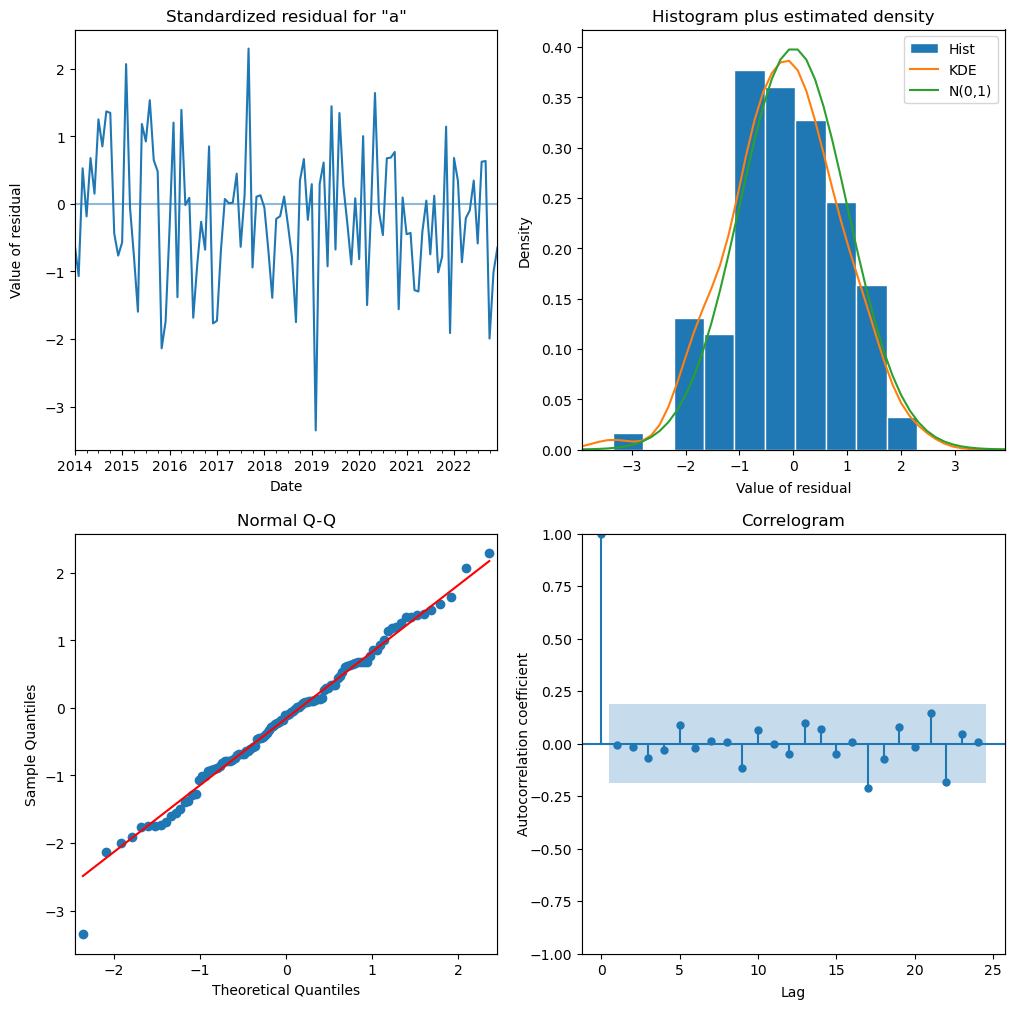

In [50]:
# Plot diagnostics
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
res_sarima_100_101.plot_diagnostics(lags=24, fig=fig)

# Modify x and y ticks and labels
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        
        # Adjust the position of the tick labels
        ax[i, j].xaxis.set_label_coords(0, -0.075)
        ax[i, j].yaxis.set_label_coords(-0.12, 0)

# Add ax labels 
#ax[0,0].set_xlabel('Time step')
ax[0,0].set_ylabel('Value of residual')
ax[0,1].set_xlabel('Value of residual')
ax[0,1].set_ylabel('Density')
ax[1,1].set_xlabel('Lag')
ax[1,1].set_ylabel('Autocorrelation coefficient')

plt.show()

In [51]:
print(res_sarima_100_101.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             avtemp   No. Observations:                  108
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -231.094
Date:                            Thu, 01 Aug 2024   AIC                            472.188
Time:                                    08:59:43   BIC                            485.598
Sample:                                01-31-2014   HQIC                           477.625
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.7710      1.446     40.633      0.000      55.936      61.606
ar.L1          0.4261      0.104   

In [52]:
# Define parameters for SARIMA model
params = {
    'order':(1,0,0),
    'seasonal':(1,0,1,12)
}

# Split train set into folds using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size = 12)

# Create empty list to store RMSE
rmse_list = []
mape_list = []

for train_index, val_index in tscv.split(df_monthly['avtemp']):
    # Split train and validation sets
    train_fold = df_monthly['avtemp'].iloc[train_index]
    test_fold = df_monthly['avtemp'].iloc[val_index]

    # Fit SARIMA model on train fold
    model = ARIMA(train_fold, order=params['order'], seasonal_order=params['seasonal'])
    res = model.fit()

    # Evaluate model on test fold
    pred = res.predict(start=test_fold.index[0], end=test_fold.index[-1])
    rmse = ((pred - test_fold) ** 2).mean() ** 0.5
    rmse_list.append(rmse)
    mape = np.mean(np.abs((test_fold - pred) / test_fold)) * 100
    mape_list.append(mape)
    print(f'RMSE: {rmse}, MAPE: {mape}%')

# Calculate average RMSE over all folds
avg_rmse = sum(rmse_list) / len(rmse_list)
avg_mape = sum(mape_list) / len(mape_list)
print(f'Average RMSE: {avg_rmse}, Average MAPE: {avg_mape}%')


RMSE: 2.233828587487493, MAPE: 3.542780750938305%


/Users/aseemmehrotra/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/aseemmehrotra/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/aseemmehrotra/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/aseemmehrotra/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible star

RMSE: 1.8199834338173277, MAPE: 2.726301570968704%


/Users/aseemmehrotra/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RMSE: 2.2168872156905626, MAPE: 3.227400096568245%
Average RMSE: 2.090233078998461, Average MAPE: 3.165494139491751%


In [53]:

# Get the out-of-sample set (the set that the model was not trained on)
oo = df_monthly[-12:]


# Read model
# Read model
model = load_pickle('sarima_100_100_12')
model_refit = model

# Set placeholders for forecasts and confidence interval limits
rolling_forecasts = []
rolling_forecasts_refit = []





In [54]:
# Predict one step at a time in a loop
for i in range(len(oo)):
    
    # Get the one-step-ahead forecast and CIs
    forecast = float(model.get_forecast(1).summary_frame()['mean'])
    forecast_refit = float(model_refit.get_forecast(1).summary_frame()['mean'])


    # Append forecast to placeholder lists
    rolling_forecasts.append(forecast)
    rolling_forecasts_refit.append(forecast_refit)
    
    # Extend model with latest observation
    model = model.append([oo['avtemp'].iloc[i]])
    model_refit = model_refit.append([oo['avtemp'].iloc[i]], refit = True)

/var/folders/sq/vvk9r1h54773x5hgxgcqlhqw0000gn/T/ipykernel_67475/1119398983.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  forecast = float(model.get_forecast(1).summary_frame()['mean'])
/var/folders/sq/vvk9r1h54773x5hgxgcqlhqw0000gn/T/ipykernel_67475/1119398983.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  forecast_refit = float(model_refit.get_forecast(1).summary_frame()['mean'])
/var/folders/sq/vvk9r1h54773x5hgxgcqlhqw0000gn/T/ipykernel_67475/1119398983.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  forecast = float(model.get_forecast(1).summary_frame()['mean'])
/var/folders/sq/vvk9r1h54773x5hgxgcqlhqw0000gn/T/ipykernel_67475/1119398983.py:6: FutureWarning: Calling float on a

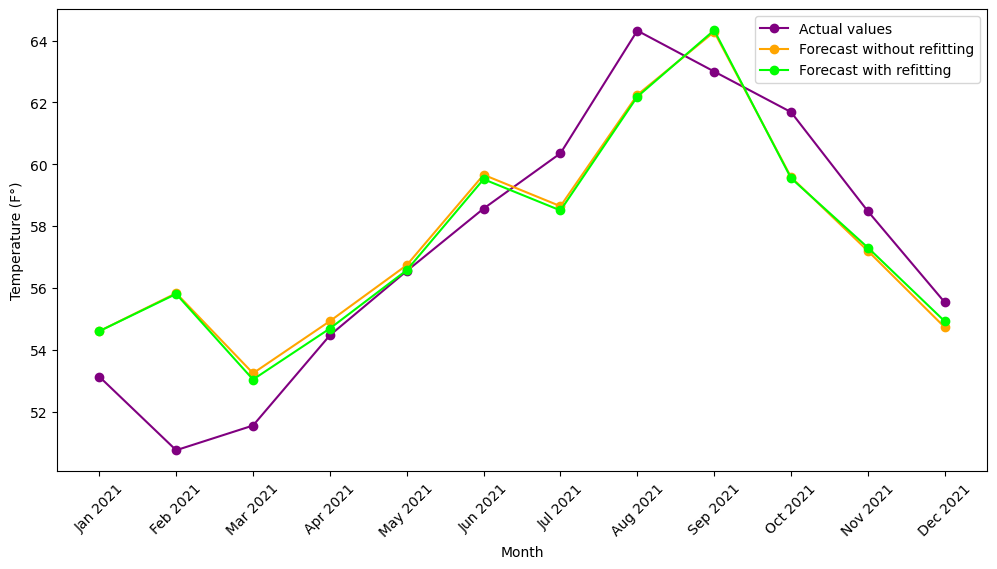

Original parameters:
 const       58.788797
ar.L1        0.454570
ar.S.L12     0.658895
sigma2       5.180368
dtype: float64 

New parameters:
 const       58.681947
ar.L1        0.506543
ar.S.L12     0.635487
sigma2       5.069958
dtype: float64


In [55]:

# Plot actual series and predictions
fig, ax = plt.subplots(1,1, figsize = (12,6))

ax.plot(oo['avtemp'].values, color = 'purple', marker = 'o', label = 'Actual values')
ax.plot(rolling_forecasts, color = 'orange', marker = 'o', label = 'Forecast without refitting')
ax.plot(rolling_forecasts_refit, color = 'lime', marker = 'o', label = 'Forecast with refitting')
ax.set_ylabel('Temperature (F°)')
ax.set_xlabel('Month')

date_range = pd.date_range(start='2021-01-01', end='2021-12-31', freq='M')
ax.set_xticks(range(len(date_range)))
ax.set_xticklabels(date_range.strftime('%b %Y'), rotation=45)

ax.legend()
plt.show()
print('Original parameters:\n', model.params, '\n')
print('New parameters:\n', model_refit.params)

In [56]:
# Load models from pickle files
res_sarima_101_100 = load_pickle('sarima_101_100_12')
res_sarima_100_100 = load_pickle('sarima_100_100_12')
res_sarima_100_200 = load_pickle('sarima_100_200_12')
res_sarima_200_100 = load_pickle('sarima_200_100_12')
res_sarima_100_200 = load_pickle('sarima_100_101_12')

# Placeholder list for MSEs
mses = []

for model in [res_sarima_101_100, res_sarima_100_100, res_sarima_100_200, res_sarima_100_100, res_sarima_100_200]:

    # Get forecasts
    forecast = model.forecast(12)

    # Calculate MSE
    mse = mean_squared_error(oo['avtemp'].values, forecast)
    mses.append(mse)

# Put MSEs in dataframe for presentation purposes
metrics = pd.DataFrame([['SARIMA(1,0,1)(1,0,0)12','SARIMA(1,0,0)(1,0,0)12','SARIMA(1,0,0)(2,0,0)12', 'SARIMA(2,0,0)(1,0,0)12', 'SARIMA(1,0,0)(1,0,1)12'],mses]).T
metrics.columns = ['Model', 'MSE']
metrics.sort_values(by='MSE')


,Model,MSE
2,"SARIMA(1,0,0)(2,0,0)12",4.914589
4,"SARIMA(1,0,0)(1,0,1)12",4.914589
1,"SARIMA(1,0,0)(1,0,0)12",6.965585
3,"SARIMA(2,0,0)(1,0,0)12",6.965585
0,"SARIMA(1,0,1)(1,0,0)12",7.511768
